In [1]:
!pip install astsadata statsmodels --upgrade

     |████████████████████████████████| 481kB 5.2MB/s 
     |████████████████████████████████| 9.5MB 9.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa as tsm
from scipy import stats
from astsadata import *

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


# Section 3.5 Estimation

In [3]:
rec_ar = sm.tsa.arima.ARIMA(rec, order=(2, 0, 0), enforce_stationarity=False, enforce_invertibility=False).fit(method="yule_walker")
print(rec_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  453
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1654.336
Date:                Fri, 14 May 2021   AIC                           3316.671
Time:                        06:21:28   BIC                           3333.117
Sample:                    01-31-1950   HQIC                          3323.152
                         - 09-30-1987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.8960      4.233     14.622      0.000      53.599      70.193
ar.L1          1.3318      0.043     30.894      0.000       1.247       1.416
ar.L2         -0.4447      0.039    -11.325      0.0

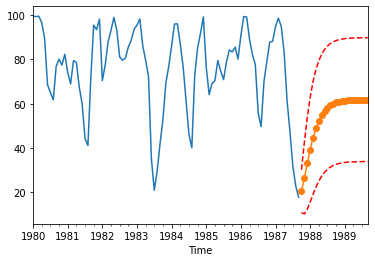

In [4]:
rec_pr = rec_ar.get_prediction(start=len(rec), end=len(rec) + 23)
U = rec_pr.predicted_mean + rec_pr.se_mean
L = rec_pr.predicted_mean - rec_pr.se_mean

rec["1980":].plot(xlabel="Time", legend=False)
rec_pr.predicted_mean.plot(marker="o")
plt.plot(U, color="red", linestyle="--")
plt.plot(L, color="red", linestyle="--")
plt.show()

In [5]:
# Example 3.29
np.random.seed(2)
ma1 = sm.tsa.arma_generate_sample(ar=[1, 0], ma=[1, .9], nsample=50)
acf1 = sm.tsa.acf(ma1, nlags=1, fft=False)[1:] # = .348 (lag 1 sample ACF)
print(acf1)

[0.34800403]


In [6]:
#-------------------- Maximum likelihood --------------------- 
# Example 3.31
rec_mle = sm.tsa.arima.ARIMA(rec, order=(2, 0, 0), enforce_stationarity=False, enforce_invertibility=False).fit(method="innovations_mle")
print(rec_mle.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  453
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1653.944
Date:                Fri, 14 May 2021   AIC                           3315.889
Time:                        06:21:29   BIC                           3332.334
Sample:                    01-31-1950   HQIC                          3322.370
                         - 09-30-1987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.8949      4.127     14.997      0.000      53.806      69.984
ar.L1          1.3512      0.041     32.832      0.000       1.271       1.432
ar.L2         -0.4612      0.037    -12.389      0.0

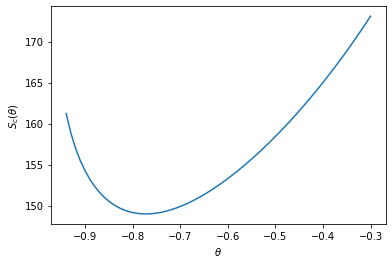

In [7]:
# Example 3.33
x = varve.apply(np.log).diff().dropna()
# Evaluate Sc on a Grid
num = x.shape[0]
w = np.zeros(num)
Sc = np.array([])
th = np.arange(-.3, -.95, -.01)

for p in np.arange(len(th)):
    for i in np.arange(1, num):
        w[i] = x.iloc[i] - th[p] * w[i-1]
    Sc = np.append(Sc, np.sum(w**2))

plt.plot(th, Sc)
plt.ylabel(r"$S_{c}(\theta)$")
plt.xlabel(r"$\theta$")
plt.show()

In [8]:
# Gauss-Newton Estimation
r = sm.tsa.acf(x, nlags=1, fft=False)[1:]
rstart = (1 - np.sqrt(1 - 4 * (r**2))) / (2 * r) # from (3.105)
w = np.zeros(num)
z = np.zeros(num)
Sc_1 = np.array([])
Sz = np.array([])
Szw = np.array([])
para = np.array([])
para = np.append(para, rstart)
niter = 12

for p in np.arange(niter):
    for i in np.arange(1, num):
        w[i] = x.iloc[i] - para[p] * w[i-1]
        z[i] = w[i-1] - para[p] * z[i-1]
    Sc_1 = np.append(Sc_1, np.sum(w**2))
    Sz = np.append(Sz, np.sum(z**2))
    Szw = np.append(Szw, np.sum(z * w))
    para = np.append(para, para[p] + Szw[p]/Sz[p])

pd.DataFrame({"iteration": np.arange(12), "thetahat": para[:niter], "Sc": Sc_1, "Sz": Sz}).round(3)

,iteration,thetahat,Sc,Sz
0,0,-0.495,158.739,171.240
1,1,-0.668,150.747,235.266
2,2,-0.733,149.264,300.562
3,3,-0.756,149.031,336.823
4,4,-0.766,148.990,354.173
5,5,-0.769,148.982,362.167
6,6,-0.771,148.980,365.801
7,7,-0.772,148.980,367.446
8,8,-0.772,148.980,368.188
9,9,-0.772,148.980,368.522


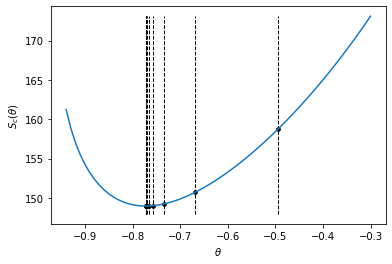

In [9]:
plt.plot(th, Sc)
plt.scatter(para[:niter], Sc_1, s=13, color="black")
plt.vlines(para[:niter], ymin=min(Sc) - 1, ymax=max(Sc), color="black", linestyles="--", linewidth=1)
plt.ylabel(r"$S_{c}(\theta)$")
plt.xlabel(r"$\theta$")
plt.show()

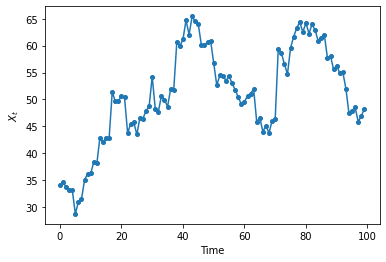

In [10]:
# Example 3.36
np.random.seed(101010)

def innov(size):
    e = np.random.exponential(scale=2, size=size)
    u = np.random.uniform(low=-1, high=1, size=size)
    return e * np.sign(u)

dex = 50 + sm.tsa.arma_generate_sample(ar=[1, -.95], ma=[1, 0], nsample=100, burnin=50, distrvs=innov)

plt.plot(dex, marker="o", markersize=4)
plt.xlabel("Time")
plt.ylabel(r"$X_{t}$")
plt.show()

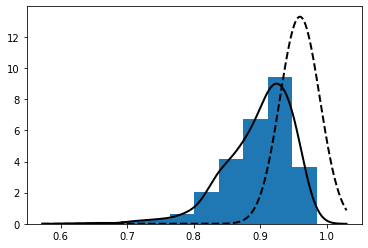

In [11]:
# small sample and asymptotic distn
np.random.seed(111)
phi_yw = np.empty(1000)

for i in np.arange(1000):
    x = 50 + sm.tsa.arma_generate_sample(ar=[1, -.95], ma=[1, 0], nsample=100, distrvs=innov, burnin=50)
    phi_yw[i] = sm.tsa.arima.ARIMA(x, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False).fit(method="yule_walker").arparams

kde = sm.nonparametric.KDEUnivariate(phi_yw).fit(bw=.015)

plt.hist(phi_yw, density=True)
plt.plot(kde.support, kde.density, lw=2, color="black")

true_values = stats.norm.pdf(loc=.96, scale=.03, x=kde.support) 
plt.plot(kde.support, true_values, lw=2, color="black", linestyle="--")
plt.show()

In [12]:
# Bootstrap
np.random.seed(666) # not that 666
fit = sm.tsa.arima.ARIMA(dex, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False).fit(method="yule_walker")
m = fit.params[0] # estimate of mean
phi = fit.arparams # estimate of phi
nboot = 250 # number of bootstrap replicates
resids = fit.resid[1:] # the 99 innovations
x_star = dex # initialize x*
phi_star_yw = np.zeros(nboot)

for i in np.arange(nboot):
    resid_star = np.random.choice(resids, size=len(resids))
    for t in np.arange(99):
        x_star[t+1] = m + phi * (x_star[t] - m) + resid_star[t]
    phi_star_yw[i] = sm.tsa.arima.ARIMA(x_star, order=(1, 0, 0), enforce_stationarity=False, enforce_invertibility=False).fit(method="yule_walker").arparams

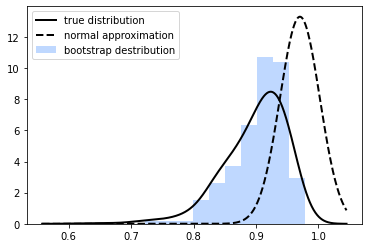

In [13]:
# Picture
kde = sm.nonparametric.KDEUnivariate(phi_yw).fit(bw=.02)

plt.hist(phi_star_yw, color=(.5, .7,1, .5), density=True, label="bootstrap destribution")
plt.plot(kde.support, kde.density, lw=2, color="black", label="true distribution")

plt.plot(kde.support, true_values, lw=2, color="black", linestyle="--", label="normal approximation")
plt.legend()
plt.show()